In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
from scipy.stats import entropy
from environments import SBEOS_Environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using device: cuda

Fold 1/5
Episode: 0, Reward: 264.20000000000005, Epsilon: 0.4738
Episode: 10, Reward: 1778.7, Epsilon: 0.0100
Episode: 20, Reward: 1786.1, Epsilon: 0.0100
Episode: 30, Reward: 1777.4, Epsilon: 0.0100
Episode: 40, Reward: 1800, Epsilon: 0.0100
Episode: 50, Reward: 1768.3, Epsilon: 0.0100
Episode: 60, Reward: 1800, Epsilon: 0.0100
Episode: 70, Reward: 1776.5, Epsilon: 0.0100
Episode: 80, Reward: 1757.3, Epsilon: 0.0100
Episode: 90, Reward: 1762.2, Epsilon: 0.0100
Episode: 100, Reward: 1750.9, Epsilon: 0.0100
Episode: 110, Reward: 1783.3, Epsilon: 0.0100
Episode: 120, Reward: 1800, Epsilon: 0.0100
Episode: 130, Reward: 1791.7, Epsilon: 0.0100
Episode: 140, Reward: 1757.3, Epsilon: 0.0100
Episode: 150, Reward: 1800, Epsilon: 0.0100
Episode: 160, Reward: 1772.8, Epsilon: 0.0100
Episode: 170, Reward: 1775.9, Epsilon: 0.0100
Episode: 180, Reward: 1773.1000000000001, Epsilon: 0.0100
Episode: 190, Reward: 1776.4, Epsilon: 0.0100

Fold 2/5
Episode: 0, Reward: 432.9, Epsilon: 

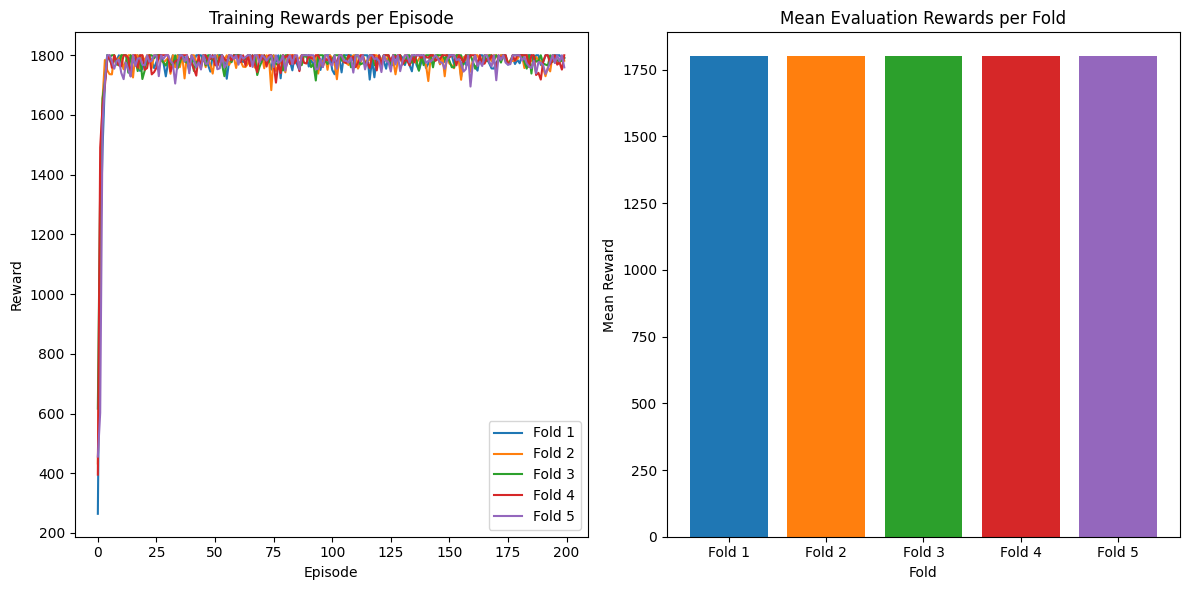

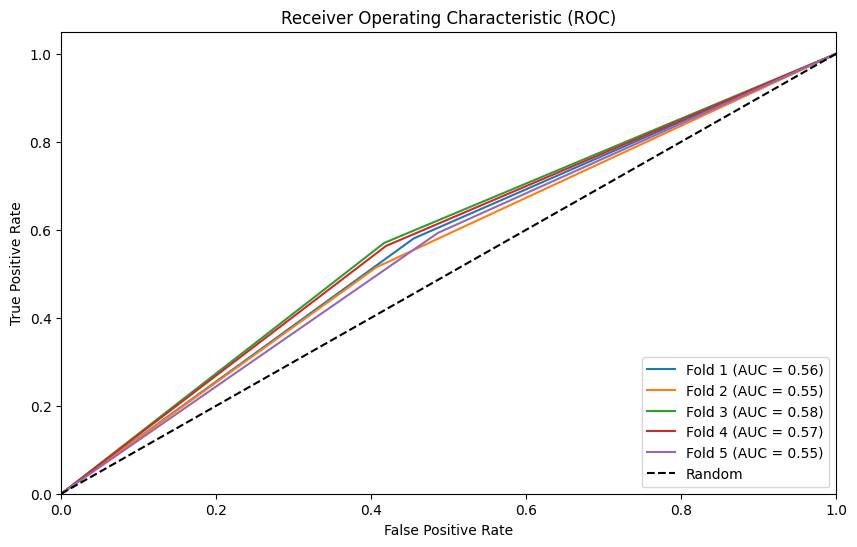

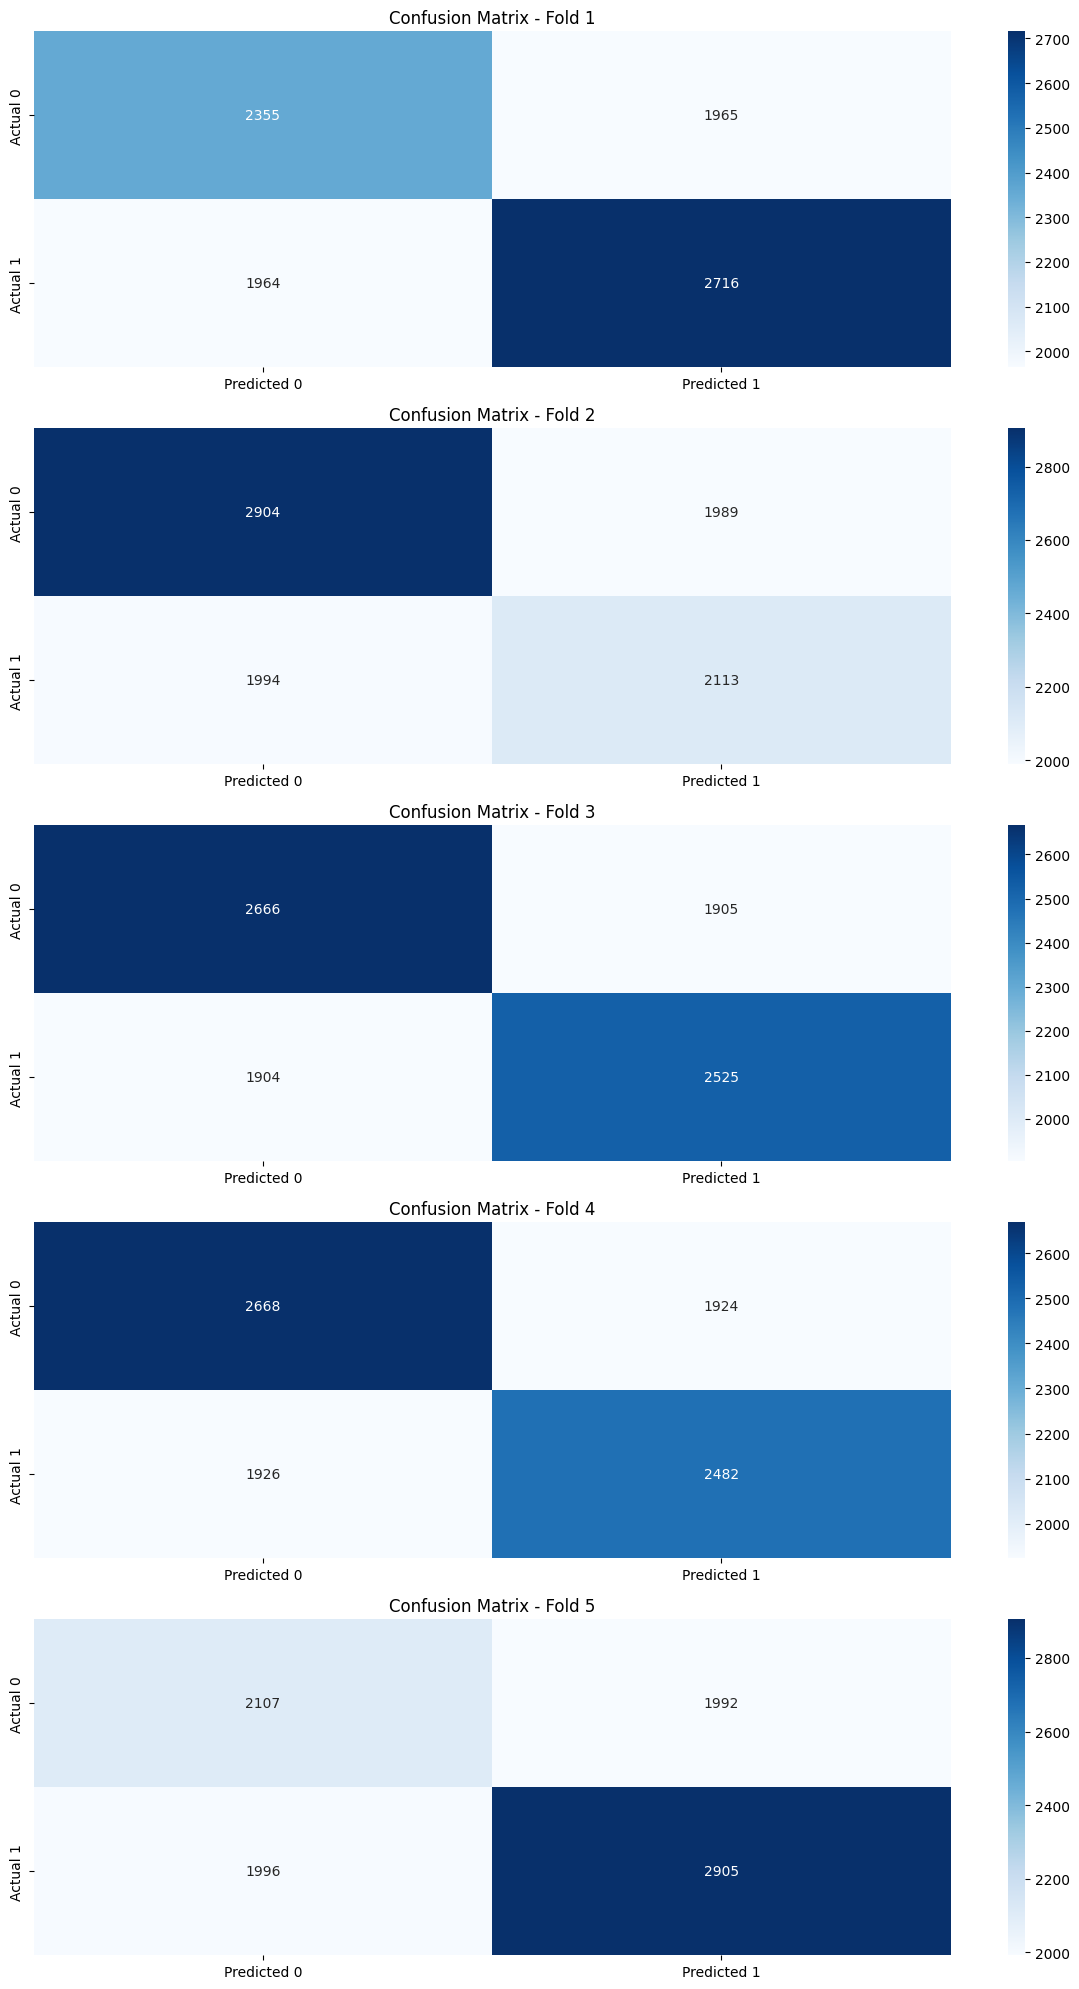

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
from scipy.stats import entropy

# Define the enhanced DQN model with larger architecture
class EnhancedDQNNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_sizes=[128, 128, 64]):
        super(EnhancedDQNNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], action_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Add batch dimension if not present
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
            
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        return self.fc4(x)

# Experience replay buffer with priorities
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001):
        self.capacity = capacity
        self.memory = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0
        self.alpha = alpha  # Priority exponent
        self.beta = beta    # Importance sampling exponent
        self.beta_increment = beta_increment
        self.max_priority = 1.0
        
        # Define Transition named tuple
        self.Transition = namedtuple('Transition', 
                                    ('state', 'action', 'reward', 'next_state', 'done'))
        
    def push(self, state, action, reward, next_state, done):
        # Store transition with max priority for new experiences
        transition = self.Transition(state, action, reward, next_state, done)
        
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
            
        # New experiences get max priority
        self.priorities[self.position] = self.max_priority
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        if len(self.memory) < batch_size:
            return None, None, None
        
        # Compute sampling probabilities
        if len(self.memory) < self.capacity:
            priorities = self.priorities[:len(self.memory)]
        else:
            priorities = self.priorities
        
        # Convert priorities to probabilities
        probs = priorities ** self.alpha
        probs /= probs.sum()
        
        # Sample indices based on priorities
        indices = np.random.choice(len(self.memory), batch_size, replace=False, p=probs)
        
        # Compute importance sampling weights
        weights = (len(self.memory) * probs[indices]) ** (-self.beta)
        weights /= weights.max()  # Normalize
        
        # Increment beta
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        # Get samples
        samples = [self.memory[idx] for idx in indices]
        
        return samples, indices, weights
    
    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
            self.max_priority = max(self.max_priority, priority)
    
    def __len__(self):
        return len(self.memory)

class ImprovedDQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.0005, gamma=0.99, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.05, 
                 batch_size=64, memory_size=50000, device="cpu",
                 target_update_freq=1000, double_dqn=True, dueling_dqn=True,
                 feature_engineering=True):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(memory_size)
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.epsilon_decay_steps = 0
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.device = device
        self.target_update_freq = target_update_freq
        self.update_counter = 0
        self.double_dqn = double_dqn
        self.dueling_dqn = dueling_dqn
        self.feature_engineering = feature_engineering
        
        # Create Q networks with improved architecture
        self.model = EnhancedDQNNetwork(state_size, action_size).to(device)
        self.target_model = EnhancedDQNNetwork(state_size, action_size).to(device)
        
        # Use Adam optimizer with learning rate decay
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=500, gamma=0.95)
        
        # Use Huber loss (more robust to outliers than MSE)
        self.criterion = nn.SmoothL1Loss(reduction='none')  # Don't reduce to enable PER weighting
        
        # Initialize target network with same weights
        self.update_target_model()
        
        # Metrics tracking
        self.loss_history = []
        self.q_values_history = []

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        # Apply feature engineering if enabled
        if self.feature_engineering:
            state = self.engineer_features(state)
            next_state = self.engineer_features(next_state)
            
        self.memory.push(state, action, reward, next_state, done)

    def engineer_features(self, state):
        """Apply feature engineering to the state"""
        # This is a placeholder - implement actual feature engineering based on your domain
        engineered_state = np.array(state, dtype=np.float32)
        
        # Example: Add non-linear transformations
        if len(engineered_state) > 0:
            # Add squared features
            squared_features = np.square(engineered_state)
            # Add log features (add small constant to avoid log(0))
            log_features = np.log(np.abs(engineered_state) + 1e-6)
            # Combine features
            engineered_state = np.concatenate([engineered_state, squared_features, log_features])
            
        return engineered_state

    def act(self, state, training=True):
        # Apply feature engineering if enabled
        if self.feature_engineering:
            state = self.engineer_features(state)
            
        # Epsilon-greedy exploration with decay
        if training and np.random.rand() <= self.epsilon:
            # Use more sophisticated exploration instead of purely random
            if np.random.rand() < 0.8:  # 80% of exploration uses semi-informed choices
                # Get action values to guide exploration
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).to(self.device)
                    act_values = self.model(state_tensor).cpu().numpy()
                
                # Add noise to action values (Boltzmann exploration)
                temperature = max(0.5, 5.0 * self.epsilon)  # Higher temp = more randomness
                exp_values = np.exp(act_values / temperature)
                probabilities = exp_values / np.sum(exp_values)
                
                return np.random.choice(self.action_size, p=probabilities)
            else:
                # Completely random 20% of the time
                return random.randrange(self.action_size)
        
        # Exploit - use the network to choose best action
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).to(self.device)
            act_values = self.model(state_tensor)
            # Track Q-values during training for diagnostics
            if training:
                self.q_values_history.append(act_values.cpu().numpy())
            return torch.argmax(act_values, dim=1).item() if act_values.dim() > 1 else torch.argmax(act_values).item()

    def replay(self):
        # Sample batch from memory
        batch, indices, weights = self.memory.sample(self.batch_size)
        if batch is None:
            return
        
        states = np.array([sample.state for sample in batch])
        actions = np.array([sample.action for sample in batch])
        rewards = np.array([sample.reward for sample in batch])
        next_states = np.array([sample.next_state for sample in batch])
        dones = np.array([float(sample.done) for sample in batch])
        
        # Convert to PyTorch tensors
        states_tensor = torch.FloatTensor(states).to(self.device)
        actions_tensor = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards_tensor = torch.FloatTensor(rewards).to(self.device)
        next_states_tensor = torch.FloatTensor(next_states).to(self.device)
        dones_tensor = torch.FloatTensor(dones).to(self.device)
        weights_tensor = torch.FloatTensor(weights).to(self.device)
        
        # Compute current Q values
        current_q_values = self.model(states_tensor).gather(1, actions_tensor)
        
        # Compute next Q values based on whether we're using Double DQN
        if self.double_dqn:
            # Double DQN: Select actions using online network
            with torch.no_grad():
                # Get actions from online network
                online_actions = self.model(next_states_tensor).argmax(dim=1, keepdim=True)
                # Get Q-values for those actions from target network
                next_q_values = self.target_model(next_states_tensor).gather(1, online_actions).squeeze(1)
        else:
            # Standard DQN: Select actions using target network
            with torch.no_grad():
                next_q_values = self.target_model(next_states_tensor).max(1)[0]
        
        # Compute target Q values
        target_q_values = rewards_tensor + (1 - dones_tensor) * self.gamma * next_q_values
        target_q_values = target_q_values.unsqueeze(1)
        
        # Compute Huber loss and weight by importance sampling weights
        td_errors = torch.abs(current_q_values - target_q_values)
        loss = self.criterion(current_q_values, target_q_values) * weights_tensor.unsqueeze(1)
        loss = loss.mean()
        
        # Update priorities in buffer
        with torch.no_grad():
            priorities = (td_errors.detach().cpu().numpy() + 1e-5)  # Add small constant to avoid zero priorities
            self.memory.update_priorities(indices, priorities)
        
        # Compute gradients and update model
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        
        self.optimizer.step()
        self.scheduler.step()
        
        # Track loss
        self.loss_history.append(loss.item())
        
        # Update target network periodically
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.update_target_model()
        
        # Epsilon decay (more sophisticated decay)
        self.epsilon_decay_steps += 1
        decay_factor = np.sqrt(self.epsilon_decay_steps)
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - 1/decay_factor))

    def load(self, name):
        self.model.load_state_dict(torch.load(name))
        self.model.eval()

    def save(self, name):
        torch.save(self.model.state_dict(), name)

def train_improved_model(env, agent, episodes=1000, early_stopping_patience=50):
    rewards_history = []
    best_reward = -float('inf')
    patience_counter = 0
    best_model_state = None
    
    # For averaging recent rewards
    recent_rewards = deque(maxlen=20)
    
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        step = 0
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            
            # Store in replay buffer
            agent.remember(state, action, reward, next_state, done)
            
            # Learn from experience
            agent.replay()
            
            state = next_state
            total_reward += reward
            step += 1
            
        # Track rewards
        rewards_history.append(total_reward)
        recent_rewards.append(total_reward)
        avg_reward = np.mean(recent_rewards) if recent_rewards else total_reward
        
        # Early stopping check
        if avg_reward > best_reward:
            best_reward = avg_reward
            patience_counter = 0
            best_model_state = agent.model.state_dict().copy()
        else:
            patience_counter += 1
        
        # Print progress
        if e % 10 == 0:
            print(f"Episode: {e}, Reward: {total_reward:.2f}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.4f}")
            
            # Also print recent average loss if available
            if agent.loss_history:
                recent_loss = np.mean(agent.loss_history[-100:]) if len(agent.loss_history) >= 100 else np.mean(agent.loss_history)
                print(f"Average Loss: {recent_loss:.6f}")
        
        # Check for early stopping
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {e} episodes. Best avg reward: {best_reward:.2f}")
            agent.model.load_state_dict(best_model_state)
            break
    
    # Load best model before returning
    if best_model_state is not None:
        agent.model.load_state_dict(best_model_state)
    
    return rewards_history, agent.loss_history, agent.q_values_history

def evaluate_model(env, agent, n_episodes=100):
    rewards = []
    true_labels = []
    predicted_labels = []
    q_values = []
    
    for _ in range(n_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            # Get Q-values and action
            with torch.no_grad():
                state_tensor = torch.FloatTensor(agent.engineer_features(state) if agent.feature_engineering else state).to(agent.device)
                q_vals = agent.model(state_tensor).cpu().numpy()
                q_values.append(q_vals)
                action = np.argmax(q_vals)
            
            next_state, reward, done, info = env.step(action)
            
            true_labels.append(info['state'] if 'state' in info else 0)  # Use 0 as default if 'state' not in info
            predicted_labels.append(action)
            
            state = next_state
            total_reward += reward
            
        rewards.append(total_reward)
    
    # Calculate ROC curve and AUC (only if binary classification)
    if len(set(true_labels)) <= 2 and len(set(predicted_labels)) <= 2:
        fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
        roc_auc = auc(fpr, tpr)
    else:
        # Multi-class or continuous values
        fpr, tpr = None, None
        roc_auc = None
    
    # Calculate confusion matrix
    unique_true = np.unique(true_labels)
    unique_pred = np.unique(predicted_labels)
    unique_all = np.unique(np.concatenate([unique_true, unique_pred]))
    n_classes = len(unique_all)
    
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(n_classes))
    
    # Calculate decision certainty (entropy of Q-values)
    avg_q_values = np.array(q_values)
    q_entropies = []
    for q in avg_q_values:
        q_softmax = softmax(q)
        q_entropies.append(entropy(q_softmax))
    
    return {
        'rewards': rewards,
        'true_labels': true_labels,
        'predicted_labels': predicted_labels,
        'roc_fpr': fpr,
        'roc_tpr': tpr,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'q_values': avg_q_values,
        'q_entropies': q_entropies
    }

def softmax(x):
    """Compute softmax values for array x."""
    e_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return e_x / np.sum(e_x)

def k_fold_cross_validation(env_class, n_folds=5, episodes_per_fold=500, n_eval_episodes=100, early_stopping_patience=50):
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Parameters for the environment
    env_params = {
        'max_timesteps': 180,
        'reward': 10,
        'penalty': 5,
        'pressure': 0.1,
        'window_size': 10
    }
    
    # Initialize the environment to get state and action dimensions
    temp_env = env_class(**env_params)
    state = temp_env.reset()
    state_size = len(state)
    
    # Allow for feature engineering expansion
    if True:  # Replace with actual feature engineering check
        # Estimate expanded state size after feature engineering
        expanded_state = np.array(state, dtype=np.float32)
        squared_features = np.square(expanded_state)
        log_features = np.log(np.abs(expanded_state) + 1e-6)
        engineered_state = np.concatenate([expanded_state, squared_features, log_features])
        state_size = len(engineered_state)
    
    action_size = 2  # 0 or 1 based on the environment
    
    # Initialize K-fold cross validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Prepare data for K-fold
    # For simplicity, we'll just use random numbers as dummy data
    X = np.random.rand(n_folds * episodes_per_fold, 1)
    y = np.random.randint(0, 2, size=(n_folds * episodes_per_fold,))
    
    fold_results = []
    
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}/{n_folds}")
        
        # Create a fresh environment for each fold
        env = env_class(**env_params)
        
        # Create a fresh agent for each fold with improved parameters
        agent = ImprovedDQNAgent(
            state_size=state_size, 
            action_size=action_size, 
            learning_rate=0.0005, 
            gamma=0.99,
            epsilon=1.0, 
            epsilon_decay=0.995, 
            epsilon_min=0.05,
            batch_size=64, 
            memory_size=50000, 
            device=device,
            target_update_freq=1000, 
            double_dqn=True, 
            dueling_dqn=True,
            feature_engineering=True
        )
        
        # Train the agent with early stopping
        rewards_history, loss_history, q_values_history = train_improved_model(
            env, agent, episodes=episodes_per_fold, early_stopping_patience=early_stopping_patience
        )
        
        # Evaluate the agent
        eval_results = evaluate_model(env, agent, n_episodes=n_eval_episodes)
        
        # Store results for this fold
        fold_results.append({
            'training_rewards': rewards_history,
            'loss_history': loss_history,
            'q_values_history': q_values_history,
            'evaluation': eval_results
        })
    
    return fold_results

def plot_enhanced_results(fold_results, n_folds):
    # Create a more comprehensive visualization
    plt.figure(figsize=(20, 16))
    
    # Plot training rewards
    plt.subplot(3, 2, 1)
    for i, result in enumerate(fold_results):
        plt.plot(result['training_rewards'], label=f'Fold {i+1}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards per Episode')
    plt.legend()
    
    # Plot loss history
    plt.subplot(3, 2, 2)
    for i, result in enumerate(fold_results):
        if 'loss_history' in result:
            # Apply moving average for smoothing
            window_size = min(100, len(result['loss_history']))
            if window_size > 0:
                smoothed_loss = np.convolve(result['loss_history'], 
                                           np.ones(window_size)/window_size, 
                                           mode='valid')
                plt.plot(smoothed_loss, label=f'Fold {i+1}')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.title('Loss During Training (Smoothed)')
    plt.yscale('log')  # Log scale often better for loss visualization
    plt.legend()
    
    # Plot evaluation rewards
    plt.subplot(3, 2, 3)
    means = [np.mean(result['evaluation']['rewards']) for result in fold_results]
    stds = [np.std(result['evaluation']['rewards']) for result in fold_results]
    plt.bar(range(n_folds), means, yerr=stds)
    plt.xlabel('Fold')
    plt.ylabel('Mean Reward')
    plt.title('Mean Evaluation Rewards per Fold')
    plt.xticks(range(n_folds), [f'Fold {i+1}' for i in range(n_folds)])
    
    # Plot ROC curves
    plt.subplot(3, 2, 4)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, result in enumerate(fold_results):
        if (result['evaluation']['roc_fpr'] is not None and 
            result['evaluation']['roc_tpr'] is not None and 
            result['evaluation']['roc_auc'] is not None):
            
            plt.plot(result['evaluation']['roc_fpr'], 
                     result['evaluation']['roc_tpr'], 
                     label=f'Fold {i+1} (AUC = {result["evaluation"]["roc_auc"]:.3f})')
            
            # Interpolate for mean calculation
            interp_tpr = np.interp(mean_fpr, result['evaluation']['roc_fpr'], result['evaluation']['roc_tpr'])
            interp_tpr[0] = 0.0
            mean_tpr += interp_tpr
    
    # Calculate mean ROC if we have valid ROC data
    if mean_tpr.any():
        mean_tpr /= n_folds
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, 'k--', 
                 label=f'Mean ROC (AUC = {mean_auc:.3f})', 
                 lw=2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    
    # Plot average Q-values
    plt.subplot(3, 2, 5)
    for i, result in enumerate(fold_results):
        if 'q_values_history' in result and result['q_values_history']:
            # Extract mean Q-value magnitude over time
            q_magnitudes = [np.mean(np.abs(q)) for q in result['q_values_history']]
            if q_magnitudes:
                # Apply moving average for smoothing
                window_size = min(50, len(q_magnitudes))
                if window_size > 0:
                    smoothed_q = np.convolve(q_magnitudes, 
                                           np.ones(window_size)/window_size, 
                                           mode='valid')
                    plt.plot(smoothed_q, label=f'Fold {i+1}')
    plt.xlabel('Training Step')
    plt.ylabel('Mean Q-Value Magnitude')
    plt.title('Q-Value Magnitude During Training')
    plt.legend()
    
    # Plot confusion matrices in a separate figure
    plt.figure(figsize=(15, n_folds * 4))
    for i, result in enumerate(fold_results):
        plt.subplot(n_folds, 1, i+1)
        cm = result['evaluation']['confusion_matrix']
        # Normalize confusion matrix for better visualization
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues',
                   xticklabels=[f'Pred {j}' for j in range(cm.shape[1])],
                   yticklabels=[f'True {j}' for j in range(cm.shape[0])])
        plt.title(f'Confusion Matrix - Fold {i+1}')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Set random seeds for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)
    random.seed(42)
    
    # Run k-fold cross validation with the improved agent
    fold_results = k_fold_cross_validation(
        env_class=SBEOS_Environment,  # Replace with your environment class
        n_folds=5, 
        episodes_per_fold=500,  # More episodes for better learning
        n_eval_episodes=100,    # More evaluation episodes for better statistics
        early_stopping_patience=50
    )
    
    # Plot enhanced results
    plot_enhanced_results(fold_results, n_folds=5)